# Dataset de textos e imagens

Criaremos um dataset que retorna imagens e um texto associado com cada imagem. Para isso, utilizaremos o dataset Oxford Pets com legendas que descrevem cada imagem do dataset

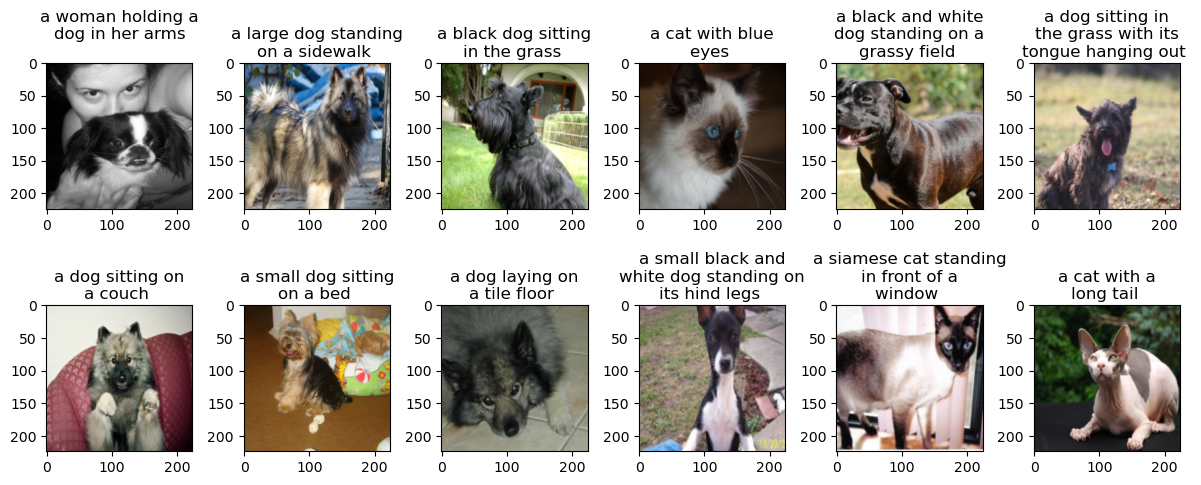

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transf

# Gambiarra para importar as funções de dataset feitas anteriormente
import sys
sys.path.insert(0, '../')
from M06_classificacao_de_imagens_naturais.dataset import OxfordIIITPet

class OxfordIIITPetCap(OxfordIIITPet):
    """Modifiação da classe OxfordIIITPet para retornar imagens e captions."""

    def __init__(self, root, cap_file, transforms=None):
        super().__init__(root)

        # Cria dicionário no qual a chave é o nome da imagem e o valor
        # é o caption
        text = open(cap_file).read().splitlines()
        cap_dict = {}
        for line in text:
            file, caption = line.split(',', 1)
            cap_dict[file.strip()] = caption.strip()
        
        # Para cada imagem, armazena o respectivo caption
        captions = []
        for filename in self.images:
            name = filename.stem
            captions.append(cap_dict[name])

        self.captions = captions
        self.transforms = transforms

    def __getitem__(self, idx):
        # Chama o método .__getitem__ da classe pai e ignora o target
        image, _ = super().__getitem__(idx)
        caption = self.captions[idx]

        if self.transforms is not None:
            image = self.transforms(image)

        # Retorna a imagem e o caption
        return image, caption
    
def wrap_text(text):
    """Função para quebrar o texto em linhas. Usada apenas para visualização
    dos dados."""
    
    text_split = text.split()
    for idx in range(len(text_split)):
        if (idx+1)%4==0:
            text_split[idx] += '\n'
        else:
            text_split[idx] += ' '
    wrapped_text = ''.join(text_split)

    return wrapped_text

def show_items(ds):
    '''Visualização dos itens to dataset.'''

    inds = torch.randint(0, len(ds), size=(12,))
    items = [ds[idx] for idx in inds]

    fig, axs = plt.subplots(2, 6, figsize=(12,5))
    axs = axs.reshape(-1)
    for idx in range(12):
        image, caption = items[idx]
        caption = wrap_text(caption)
        axs[idx].imshow(image.permute(1, 2, 0)/255.)
        axs[idx].set_title(caption, loc='center', wrap=True)
    fig.tight_layout()

transforms = transf.Compose([
    transf.PILToTensor(),   
    transf.RandomResizedCrop(size=(224,224), scale=(0.8,1.), ratio=(0.7,1.3)),
    transf.RandomHorizontalFlip(),
    transf.ToDtype(torch.float32),
])

ds = OxfordIIITPetCap('../data/oxford_pets', '../data/oxford_pets_captions.txt', 
                      transforms=transforms)
show_items(ds)

Vamos criar uma função collate_fn para definição dos batches. Para simplificar, não vamos criar um tensor para o texto. Para fazer isso teríamos que tokenizar o texto dentro do dataset. Vamos deixar a tokenização para o modelo de codificação do texto.

In [2]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    """Concatena imagens, mas não os textos"""

    images, texts = list(zip(*batch))
    batched_imgs = torch.stack(images, 0)

    return batched_imgs, texts

dl = DataLoader(ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
imgs, texts = next(iter(dl))

### Como as legendas foram geradas

O dataset Oxford Pets não possui legendas para as imagens. Para quem tiver curiosidade, o código abaixo foi usado para gerar as descrições das imagens da base. Foi utilizado um modelo pré-treinado de geração de legendas.

In [ ]:
import json
from transformers import pipeline

import sys
sys.path.insert(0, '../')
from M06_classificacao_de_imagens_naturais.dataset import OxfordIIITPet

# Cuidado, o modelo abaixo é gigante!
pipe = pipeline(model="Salesforce/blip2-opt-2.7b", task="image-to-text")
ds = OxfordIIITPet('../data/oxford_pets')
resume = True   #True=continuar de onde parou

if resume:
    results = json.load(open('../data/oxford_pets_captions.json', 'r'))
    start_idx = max(map(int, results.keys())) + 1
else:
    results = {}
    start_idx = 0

for idx in range(start_idx, len(ds)):
    if idx%10==0:
        print(idx)
    name = ds.images[idx].name
    img, _ = ds[idx]
    # Gera o caption e salva em um dicionário
    desc = pipe(img, max_new_tokens=20)[0]['generated_text'].strip()
    results[str(idx)] = [name, desc]

    json.dump(results, open('../data/oxford_pets_captions.json', 'w'))